In [1]:
using DifferentialEquations
using Plots

Consider the simple reaction:

$$A \longleftrightarrow B$$

It is an elementary step and proceeds through a transition state.  It occurs in the liquid phase, and we will consider it in a few different solvent environments.

In [22]:
gammaA(XA, XS, A12A, A21A) = exp.(XS.^2 .*(A12A .+ 2*(A21A - A12A)*XA))
gammaTS(XTS, XS, A12TS, A21TS) = exp.(XS.^2 .*(A12TS .+ 2*(A21TS - A12TS)*XTS))
gammaB(XB, XS, A12B, A21B) = exp.(XS.^2 .*(A12B .+ 2*(A21B - A12B)*XB))
z(XA, XB, XS, A12A, A21A, A12B, A21B) = 1/K10*gammaB(XB, XS, A12B, A21B)./gammaA(XA, XS, A12A, A21A).*XB./XA
rate(XA, XB, XTS, XS, A12A, A21A, A12B, A21B, A12TS, A21TS) = k10*gammaA(XA, XS, A12A, A21A)./gammaTS(XTS, XS, A12TS, A21TS).*XA.*(1 .- z(XA, XB, XS, A12A, A21A, A12B, A21B))

rate (generic function with 1 method)

In [26]:
function batch(du, u, p, t)
    MAR = p["MAR"]
    PAR = p["PAR"]

    k10, K10, V, NS = PAR
    
    NA = u[1]
    NB = u[2]
    NT = NA + NB + NS
    
    XA  = NA/NT
    XB  = NB/NT
    XTS = 0
    XS  = NS/NT
    
    #For A in solvent
    A12A = MAR[1]
    A21A = MAR[2]

    #For B in solvent
    A12B = MAR[3]
    A21B = MAR[4]
    
    #For Transition State in solvent
    A12TS = MAR[5]
    A21TS = MAR[6]
    
    RA = -rate(XA, XB, XTS, XS, A12A, A21A, A12B, A21B, A12TS, A21TS)*NT/V
    RB =  rate(XA, XB, XTS, XS, A12A, A21A, A12B, A21B, A12TS, A21TS)*NT/V
    
    du[1] = RA*V
    du[2] = RB*V
end

batch (generic function with 1 method)

In [29]:
k10  = 1
K10  = 1
V    = 1
NTOT = 100
NA0  = 0.1
NB0  = 0.0
NS   = NTOT - NA0 - NB0
var0 = [NA0, NB0]
span = (0.0, 10.0);

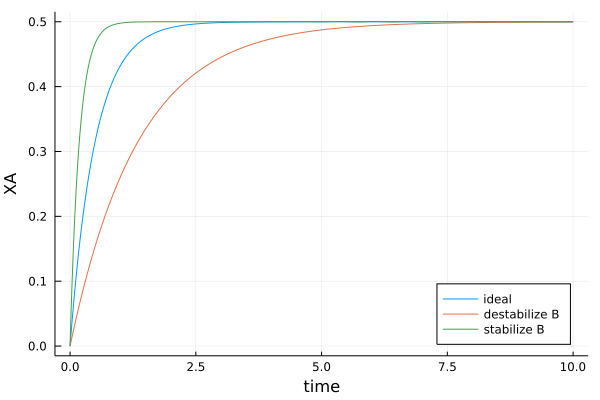

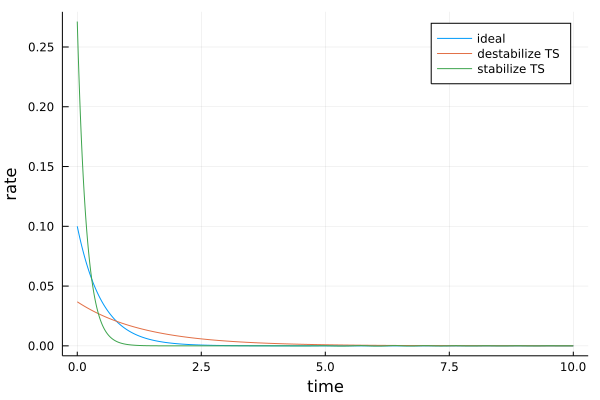

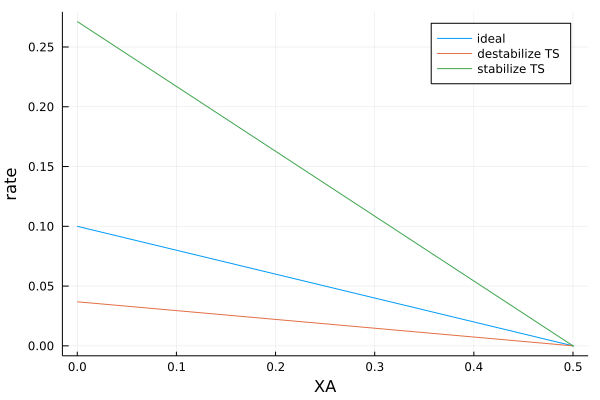

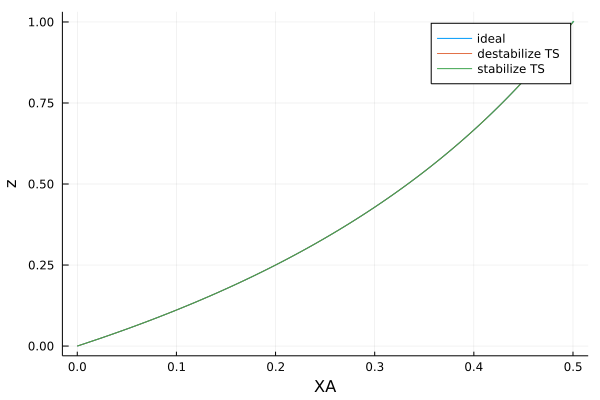

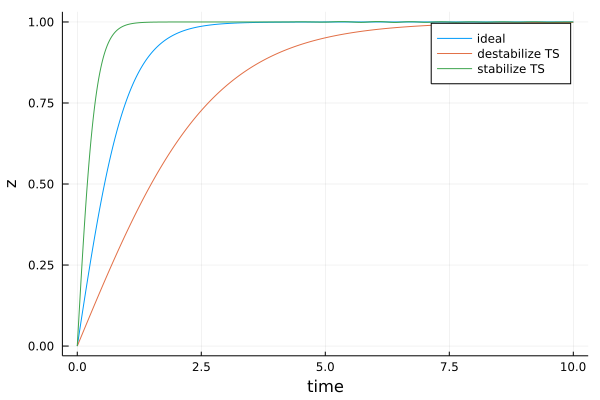

In [34]:
#Solvate transition state relative to reactants
MARSET1 = zeros(6,3)
MARSET1[:,1] = [0.0, 0.0, 0.0,  0.0,  0.0, 0.0] #no solvation
MARSET1[:,2] = [0.0, 0.0, 0.0,  0.0,  1.0, 0.0] #destabilize TS
MARSET1[:,3] = [0.0, 0.0, 0.0,  0.0, -1.0, 0.0] #stabilize TS

tfine  = range(0.0, stop = maximum(span), length = 1000)
Xout   = zeros(length(tfine), size(MARSET1, 2))
rout   = zeros(length(tfine), size(MARSET1, 2))
zout   = zeros(length(tfine), size(MARSET1, 2))

for i = 1:size(MARSET1, 2)
    p0   = Dict("MAR" => MARSET1[:,i], "PAR" => [k10, K10, V, NS])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NT   = NA + NB .+ NS
    XA   = (NA0 .- NA)/NA0
    xa   = NA./NT
    xb   = NB./NT
    xt   = 0
    xs   = NS./NT
    pt   = p0["MAR"]
    rt   = rate(xa, xb, xt, xs, pt[1], pt[2], pt[3], pt[4], pt[5], pt[6])*NTOT/V
    zt   = z(xa, xb, xs, pt[1], pt[2], pt[3], pt[4])
    
    Xout[:,i] = XA
    rout[:,i] = rt
    zout[:,i] = zt
end

plt1 = plot(tfine, Xout, xlabel = "time", ylabel = "XA", labels = ["ideal" "destabilize B" "stabilize B"], legend = :bottomright)
plt2 = plot(tfine, rout, xlabel = "time", ylabel = "rate", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :topright)
plt3 = plot(Xout, rout, xlabel = "XA", ylabel = "rate", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :topright)
plt4 = plot(Xout, zout, xlabel = "XA", ylabel = "z", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :topright)
plt5 = plot(tfine, zout, xlabel = "time", ylabel = "z", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :topright)

display(plt1)
display(plt2)
display(plt3)
display(plt4)
display(plt5)

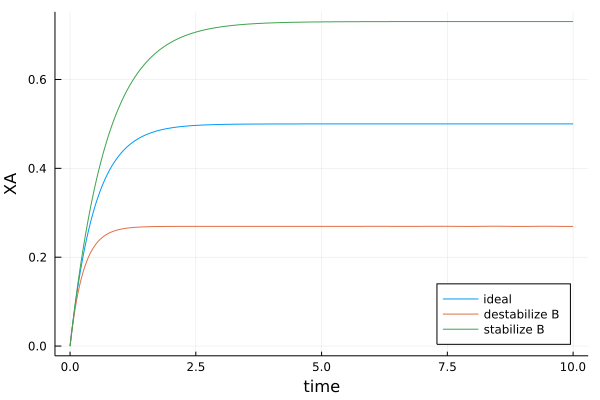

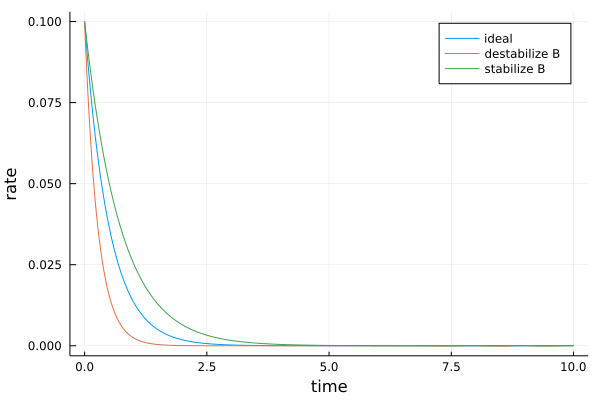

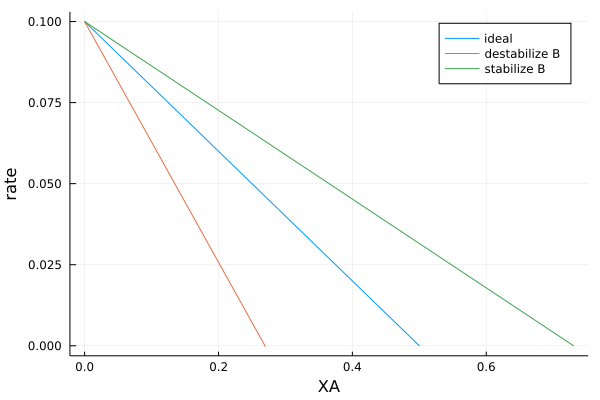

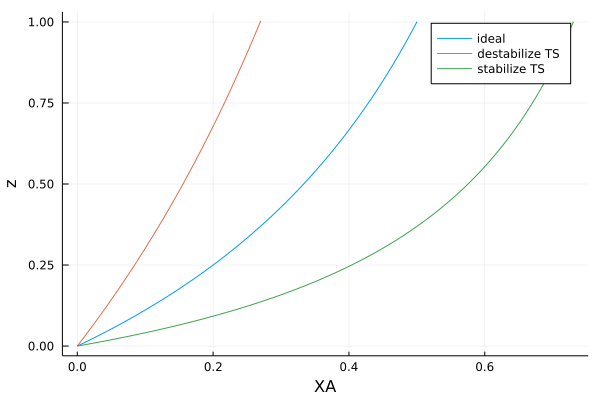

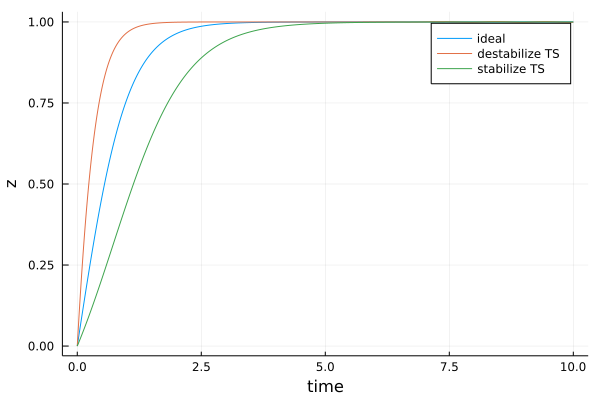

In [35]:
MARSET2 = zeros(6,3)
MARSET2[:,1] = [0.0, 0.0,  0.0, 0.0, 0.0, 0.0]
MARSET2[:,2] = [0.0, 0.0,  1.0, 0.0, 0.0, 0.0]
MARSET2[:,3] = [0.0, 0.0, -1.0, 0.0, 0.0, 0.0]

tfine  = range(0.0, stop = maximum(span), length = 1000)
Xout   = zeros(length(tfine), size(MARSET2, 2))
rout   = zeros(length(tfine), size(MARSET2, 2))
zout   = zeros(length(tfine), size(MARSET2, 2))

for i = 1:size(MARSET2, 2)
    p0   = Dict("MAR" => MARSET2[:,i], "PAR" => [k10, K10, V, NS])
    prob = ODEProblem(batch, var0, span, p0)
    sol  = solve(prob)
    solf = sol(tfine)
    NA   = solf[1,:]
    NB   = solf[2,:]
    NT   = NA + NB .+ NS
    XA   = (NA0 .- NA)/NA0
    xa   = NA./NT
    xb   = NB./NT
    xt   = 0
    xs   = NS./NT
    pt   = p0["MAR"]
    rt   = rate(xa, xb, xt, xs, pt[1], pt[2], pt[3], pt[4], pt[5], pt[6])*NTOT/V
    zt   = z(xa, xb, xt, xs, pt[1], pt[2], pt[3], pt[4], pt[5], pt[6])
    
    Xout[:,i] = XA
    rout[:,i] = rt
    zout[:,i] = zt
end

plt1 = plot(tfine, Xout, xlabel = "time", ylabel = "XA", labels = ["ideal" "destabilize B" "stabilize B"], legend = :bottomright)
plt2 = plot(tfine, rout, xlabel = "time", ylabel = "rate", labels = ["ideal" "destabilize B" "stabilize B"], legend = :topright)
plt3 = plot(Xout, rout, xlabel = "XA", ylabel = "rate", labels = ["ideal" "destabilize B" "stabilize B"], legend = :topright)
plt4 = plot(Xout, zout, xlabel = "XA", ylabel = "z", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :topright)
plt5 = plot(tfine, zout, xlabel = "time", ylabel = "z", labels = ["ideal" "destabilize TS" "stabilize TS"], legend = :topright)

display(plt1)
display(plt2)
display(plt3)
display(plt4)
display(plt5)